### Table of Contents

1. [Loading libraries and data](#loading_lib_data)
    - 1.1 [Libraries](#libraries)
    - 1.2 [Raw data](#raw_data)
2. [Exploratory Data Analysis](#eda)
    - 2.1 [Data Initial Cleanup](#initial_cleanup)
    - 2.2 [Data Visualisation](#visualisation)
3. [Data preprocessing](#data_preprocessing)
    - 3.1 [One Hot Encoding](#ohe)
    - 3.2 [Principal Component Analysis](#pca)
    - 3.3 [Scaling and PCA](#scale_pca)
4. [Testing basic classifiers](#testing_classifiers)

### 1. Loading libraries and data <a class="anchor" id="loading_lib_data"></a>

#### 1.1 Libraries <a class="anchor" id="libraries"></a>

In [1]:
import pandas as pd
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

#### 1.2 Raw Data <a class="anchor" id="raw_data"></a>

In [2]:
data = pd.read_csv('./data/travel_accommodation.txt', header=None)
        
print(data.iloc[:20])
print('\nData length: {}'.format(len(data)))

                 0
0   [1] "Record 1"
1      [1] 1010286
2            [1] 7
3            [1] F
4           [1] 40
5            [1] 0
6           [1] SE
7          [1] Apt
8   [1] "Record 2"
9      [1] 1000152
10           [1] 5
11           [1] M
12        [1] <NA>
13           [1] 0
14        [1] <NA>
15         [1] Apt
16  [1] "Record 3"
17     [1] 1009019
18           [1] 4
19           [1] F

Data length: 78944


### 2. Exploratory Data Analysis <a class="anchor" id="eda"></a>

#### 2.1 Data Initial Cleanup <a class="anchor" id="initial_cleanup"></a>

In [3]:
cols = ['id','durationOfStay', 'gender', 'Age', 'kids'
         , 'destinationCode', 'AcomType']
tmp = [x.replace('[1] ','') for x in data[0]]
tmp = [float('NaN') if x=='<NA>' else x for x in tmp]
lst = []
clen = len(cols)
i=1
while i<len(data):
    lst.append(tmp[i:i+7])
    i+=clen+1

df = pd.DataFrame(lst)
df.columns = cols
print(df.iloc[:10])

        id durationOfStay gender  Age kids destinationCode AcomType
0  1010286              7      F   40    0              SE      Apt
1  1000152              5      M  NaN    0             NaN      Apt
2  1009019              4      F   39    1              ES    Hotel
3  1007840              5      F   45    0              NL    Hotel
4  1006939              5      M   45    1              UK    Hotel
5  1008812              7      F   47    1              IT      Apt
6  1013918              3      F   53    0              NL    Hotel
7  1005722              2      F   47    0              FI    Hotel
8  1003006              3      M   39    1              SE      Apt
9  1006149              5      F   31  NaN              FI      Apt


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9868 entries, 0 to 9867
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               9868 non-null   object
 1   durationOfStay   9868 non-null   object
 2   gender           9868 non-null   object
 3   Age              8874 non-null   object
 4   kids             8897 non-null   object
 5   destinationCode  8872 non-null   object
 6   AcomType         9868 non-null   object
dtypes: object(7)
memory usage: 539.8+ KB


In [5]:
df.isnull().sum()

id                   0
durationOfStay       0
gender               0
Age                994
kids               971
destinationCode    996
AcomType             0
dtype: int64

In [6]:
print('Initial size: {}'.format(df.shape))
print('Drop NA size: {}'.format(df.dropna().shape))

Initial size: (9868, 7)
Drop NA size: (7202, 7)


In [7]:
df = df.dropna()

In [8]:
df.describe()

,id,durationOfStay,gender,Age,kids,destinationCode,AcomType
count,7202,7202,7202,7202,7202,7202,7202
unique,7202,12,2,37,2,8,2
top,1010286,4,F,40,1,BE,Hotel
freq,1,1651,3627,572,3628,947,4084


#### 2.2 Data Visualisation <a class="anchor" id="visualisation"></a>

In [9]:
def plot_stacked_bar_chart(df, groups, title):
    gp = df.groupby(groups)[groups[1]].count()
    gp = gp.unstack()
    gp['total'] = gp.iloc[:,:2].sum(axis=1)
    gp = gp.sort_values(by=['total'])
    gp = gp.drop(columns=['total'])
    gp.plot(kind='barh',stacked=True, color = ["#FF6961","#A7C7E7"],
                  linewidth = 1, grid=True, figsize=(15,8), width=0.5)
    plt.title(title, fontsize=16)
    plt.xlabel('Number of acoms', fontsize=12)
    plt.ylabel("")
    plt.legend(loc = 4,prop = {"size" : 13})
    plt.rc('ytick', labelsize=13)
    for i, v in enumerate(gp.iloc[:,0]):
        plt.text(1.5*v, i + .27, str(v), color='black', fontweight='bold')
    for i, v in enumerate(gp.iloc[:,1]):
        plt.text(0.5*v, i + .27, str(v), color='black', fontweight='bold')
    plt.show()

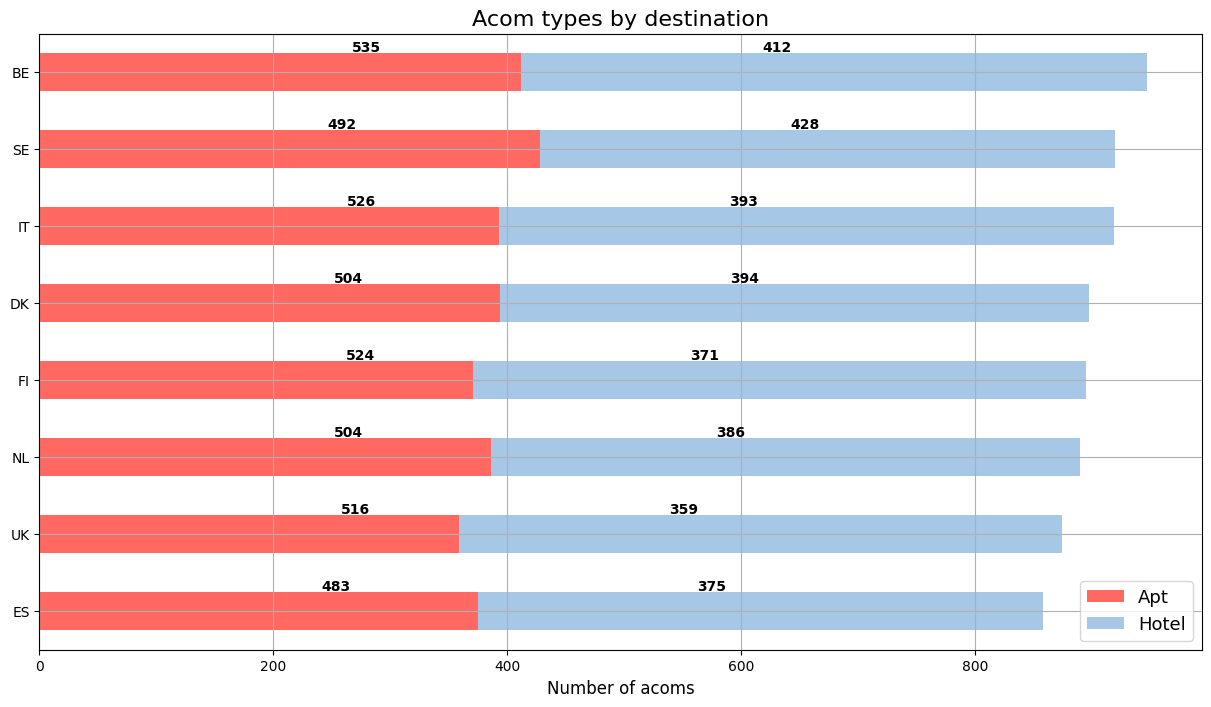

In [10]:
plot_stacked_bar_chart(df, ['destinationCode','AcomType'], 'Acom types by destination')

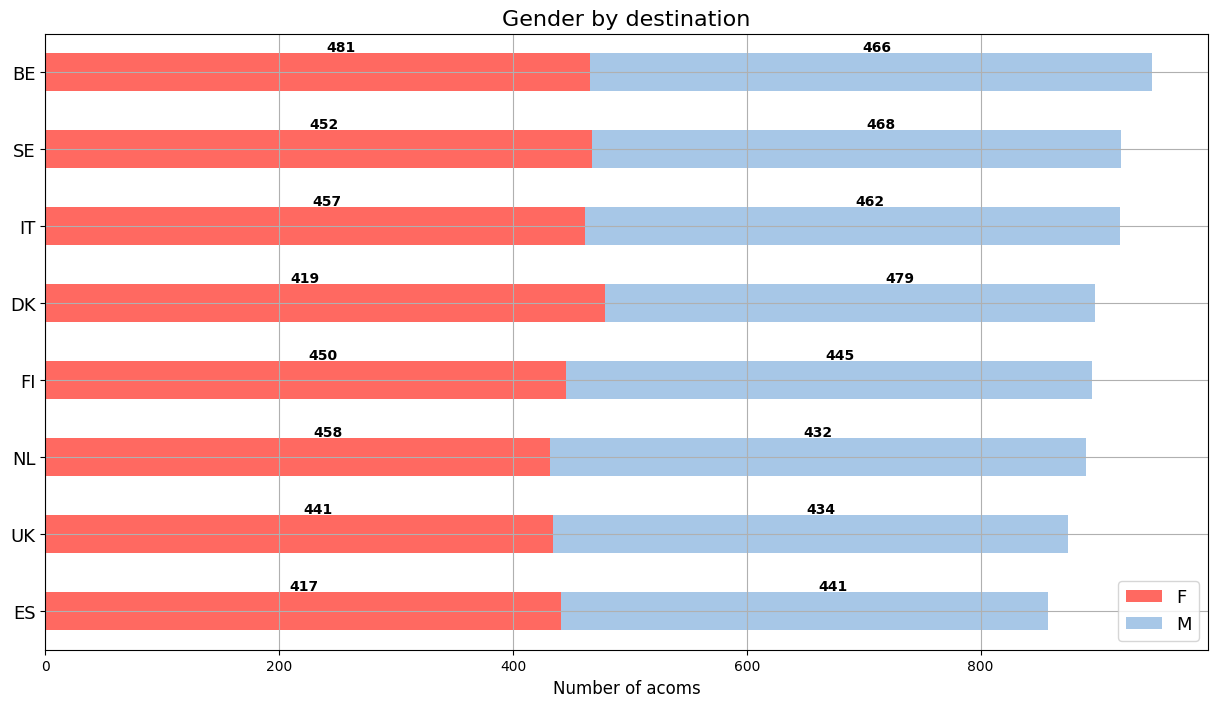

In [11]:
plot_stacked_bar_chart(df, ['destinationCode', 'gender'], 'Gender by destination')

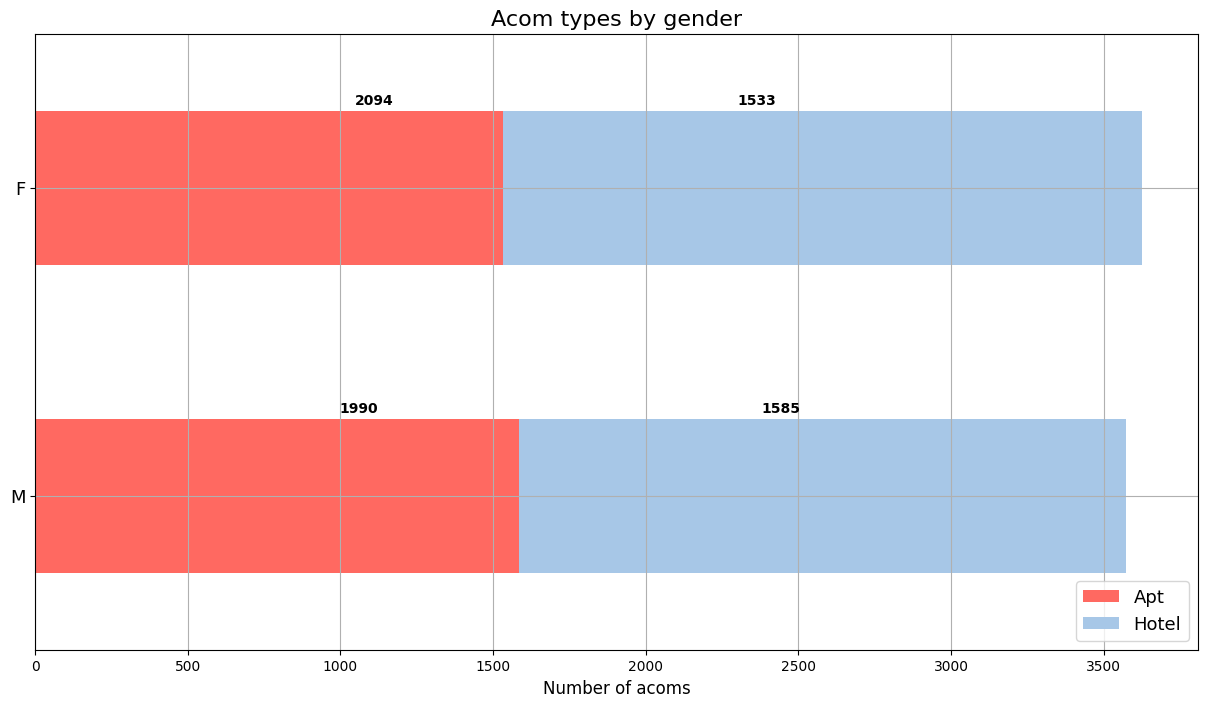

In [12]:
plot_stacked_bar_chart(df, ['gender','AcomType'], 'Acom types by gender')

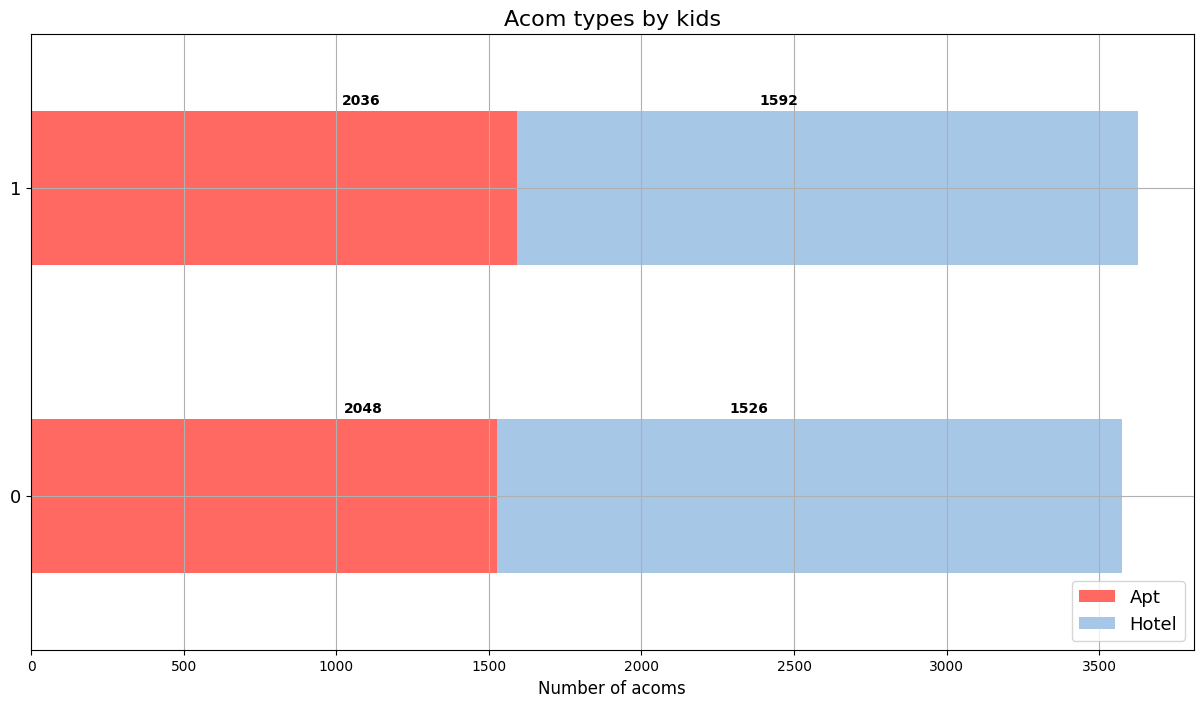

In [13]:
plot_stacked_bar_chart(df, ['kids','AcomType'], 'Acom types by kids')

In [14]:
def plot_distribution(df,column):
    x = pd.to_numeric(df[column])
    plt.figure(figsize=(15,8))
    sns.histplot(x, stat="density", 
             color = '#A7C7E7')
    sns.kdeplot(x, color="#FF6961", bw_adjust=1.5)
    plt.title('{} density'.format(column), fontsize=16)
    plt.xlabel(column, fontsize=12)
    plt.show()

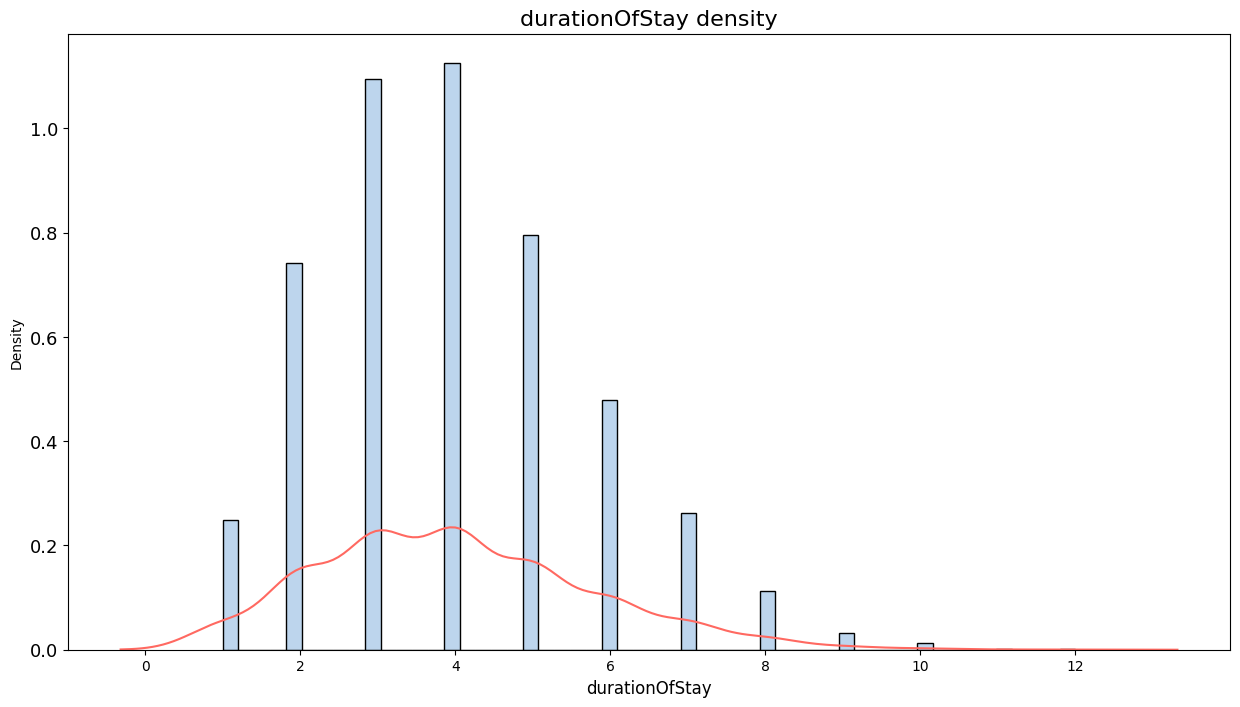

In [15]:
plot_distribution(df, 'durationOfStay')

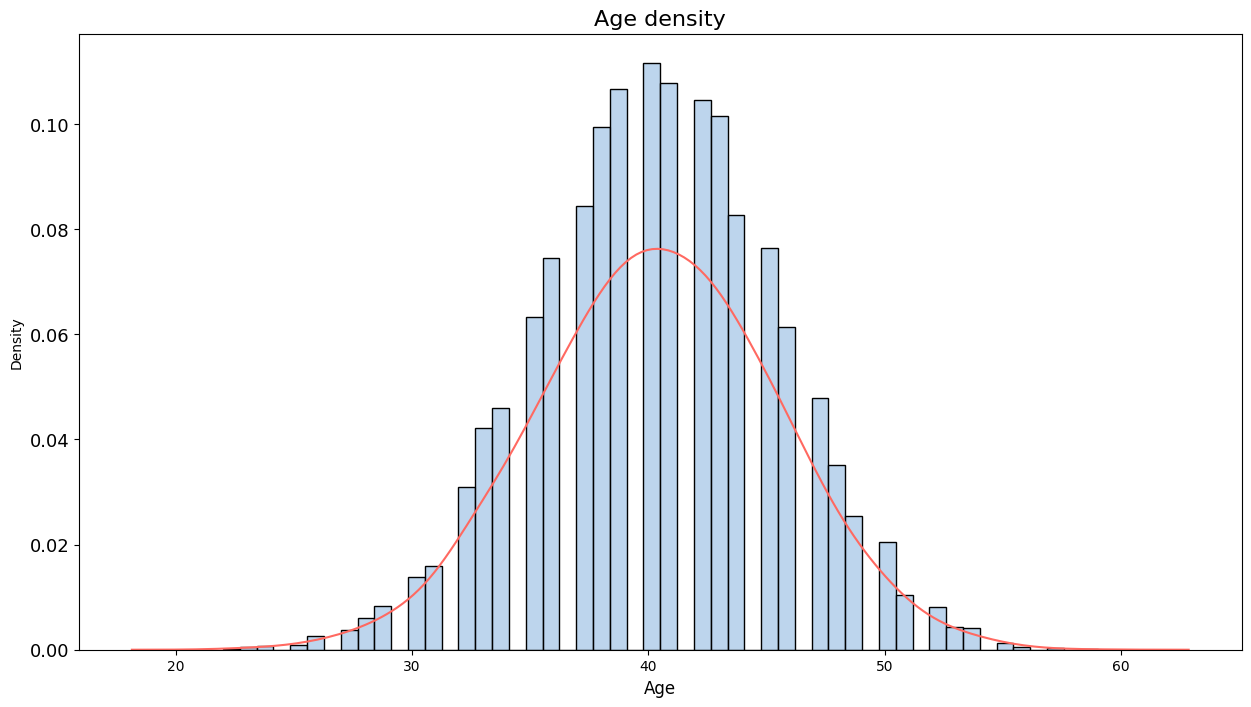

In [16]:
plot_distribution(df, 'Age')

### 3. Data Preprocessing <a class="anchor" id="data_preprocessing"></a>

#### 3.1 One Hot Encoding <a class="anchor" id="ohe"></a>

In [17]:
df['AcomType'] = df['AcomType'].map({'Apt':1, 'Hotel':0})
df['gender'] = df['gender'].map({'M':1, 'F':0})
df = df.drop(['id'], axis=1)
ohe = pd.get_dummies(df['destinationCode'], prefix='dest_code')
df = pd.concat([df, ohe], axis=1, join='inner')
df = df.drop(['destinationCode'], axis=1)
print(df[:10])

   durationOfStay  gender Age kids  AcomType  dest_code_BE  dest_code_DK  \
0               7       0  40    0         1             0             0   
2               4       0  39    1         0             0             0   
3               5       0  45    0         0             0             0   
4               5       1  45    1         0             0             0   
5               7       0  47    1         1             0             0   
6               3       0  53    0         0             0             0   
7               2       0  47    0         0             0             0   
8               3       1  39    1         1             0             0   
10              4       1  34    1         1             0             1   
12              7       1  37    1         1             0             0   

    dest_code_ES  dest_code_FI  dest_code_IT  dest_code_NL  dest_code_SE  \
0              0             0             0             0             1   
2          

In [18]:
y = df['AcomType']
x = df.drop(['AcomType'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=13)


#### 3.2 Principal Component Analysis <a class="anchor" id="pca"></a>

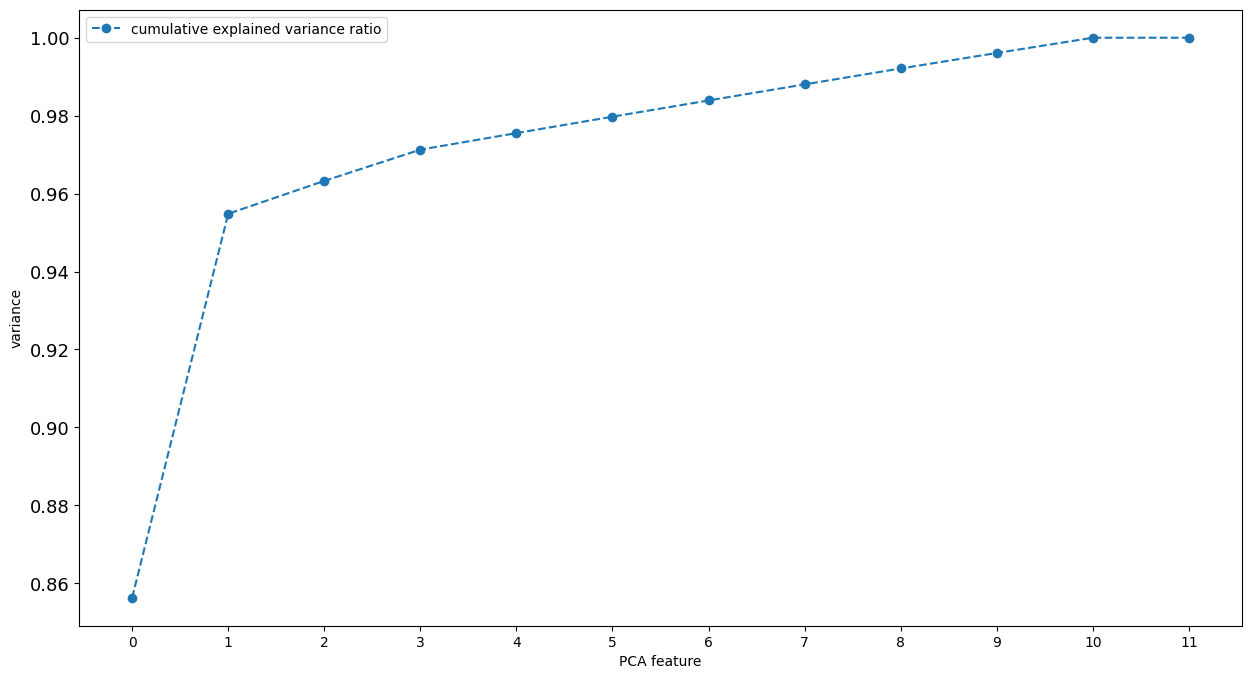

In [19]:
pca = PCA()

pca.fit(X_train)
plt.figure(figsize=(15, 8))
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_ratio_.cumsum(),'--o', label='cumulative explained variance ratio')
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.legend()
plt.show()

In [20]:
pca = PCA(n_components=1)

pca.fit(X_train)

pca1_X_train = pca.transform(X_train)
pca1_X_test = pca.transform(X_test)
print('pca_X_train shape: {}'.format(pca1_X_train.shape))
print('pca_X_test shape: {}'.format(pca1_X_test.shape))

pca_X_train shape: (5401, 1)
pca_X_test shape: (1801, 1)


#### 3.3 Scaling and PCA <a class="anchor" id="scale_pca"></a>

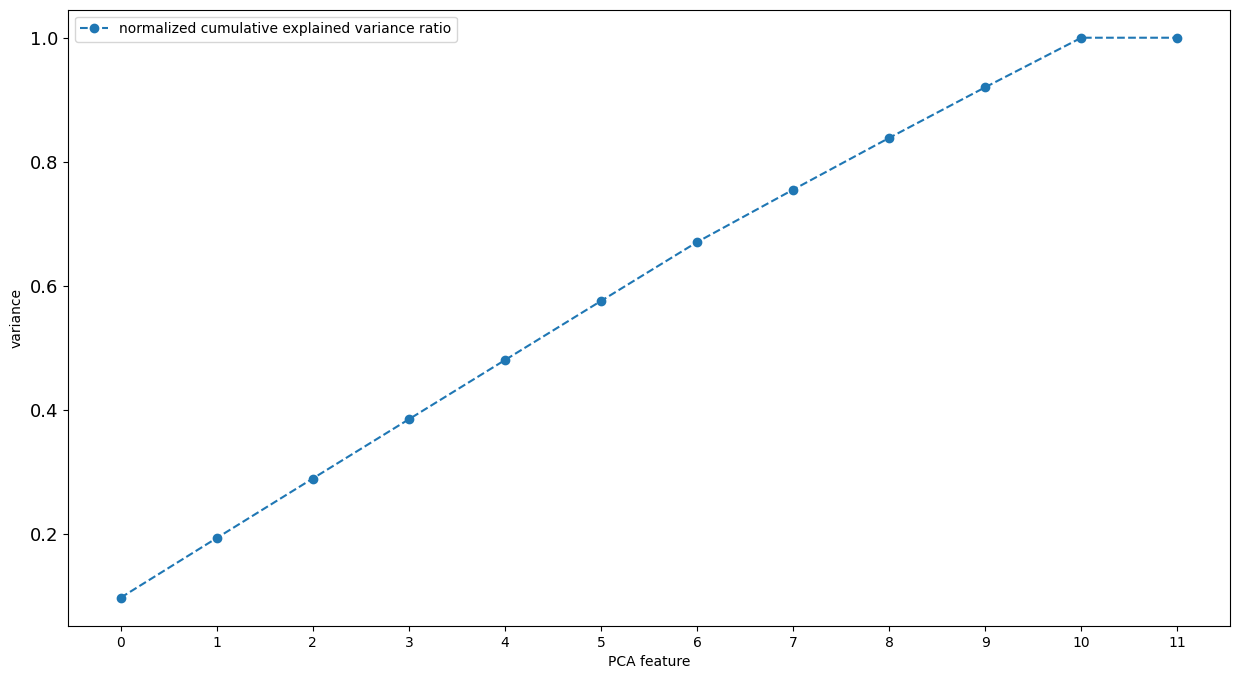

In [21]:
scaler = StandardScaler()

pca = PCA()

pipeline = make_pipeline(scaler, pca)

pipeline.fit(X_train)

plt.figure(figsize=(15, 8))
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_ratio_.cumsum(),'--o', label='normalized cumulative explained variance ratio')
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.legend()
plt.show()

In [22]:
scaler = StandardScaler()

pca = PCA(n_components=10)

pipeline = make_pipeline(scaler, pca)

np_train = X_train.to_numpy()
np_test = X_test.to_numpy()
pipeline.fit(np_train)

sc_pca10_X_train = pca.transform(np_train)
sc_pca10_X_test = pca.transform(np_test)

print('pca10_X_train shape: {}'.format(sc_pca10_X_train.shape))
print('pca10_X_test shape: {}'.format(sc_pca10_X_test.shape))

pca10_X_train shape: (5401, 10)
pca10_X_test shape: (1801, 10)


### 4. Testing basic classifiers <a class="anchor" id="testing_classifiers"></a>

In [23]:
def get_model_results(X_train, y_train, X_test, y_test):
    results={}
    def test_model(model):
        start_time = time.time()
        
        model.fit(X_train, y_train)
        test_accuracy = model.score(X_test, y_test)
        model_probs = model.predict_proba(X_test)
        model_bin = model.predict(X_test)
        test_log_loss = log_loss(y_test, model_probs)
        test_roc_auc = roc_auc_score(y_test, model_probs[:, 1])
        test_f1 = f1_score(y_test, model_bin)
        cv_acc = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5)
        
        scores= [cv_acc.mean(), test_accuracy, test_log_loss, test_roc_auc, test_f1, (time.time() - start_time)]
        return scores
    
    m = DecisionTreeClassifier()
    results['Decision tree 2'] = test_model(m)
    
    m = LogisticRegression()
    results['Logistic Regression'] = test_model(m)
    
    m = RandomForestClassifier()
    results['Random forest 100'] = test_model(m)
    
    m = KNeighborsClassifier()
    results['KNN 5'] = test_model(m)
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=['CV mean accuracy', 'Test accuracy', 'Test log loss', 'Test AUC', 'Test F1', 'Time duration (sec)'] 
    results=results.sort_values(by=['Test accuracy','Test log loss'],ascending=[False,True])

    return results

In [24]:
results = get_model_results(X_train, y_train, X_test, y_test)
results

,CV mean accuracy,Test accuracy,Test log loss,Test AUC,Test F1,Time duration (sec)
Random forest 100,0.785411,0.791227,1.024969,0.831622,0.764411,3.188707
Decision tree 2,0.749676,0.774014,6.156030,0.788206,0.730642,0.169394
KNN 5,0.685981,0.681843,1.715633,0.715062,0.623274,0.519929
Logistic Regression,0.568598,0.562465,0.685568,0.514390,0.000000,0.305182


In [25]:
pca1_results = get_model_results(pca1_X_train, y_train, pca1_X_test, y_test)
pca1_results

,CV mean accuracy,Test accuracy,Test log loss,Test AUC,Test F1,Time duration (sec)
Decision tree 2,0.693761,0.710716,8.338957,0.714682,0.654738,0.218000
Random forest 100,0.696169,0.710161,2.147730,0.737591,0.666240,9.111444
KNN 5,0.628775,0.648529,2.278078,0.684090,0.579960,0.280775
Logistic Regression,0.568598,0.562465,0.685359,0.507917,0.000000,0.037256


In [26]:
sc_pca10_results = get_model_results(sc_pca10_X_train, y_train, sc_pca10_X_test, y_test)
sc_pca10_results

,CV mean accuracy,Test accuracy,Test log loss,Test AUC,Test F1,Time duration (sec)
Random forest 100,0.737641,0.756802,0.903461,0.804156,0.718870,9.867913
Decision tree 2,0.718571,0.739034,7.339846,0.747645,0.690382,0.333534
KNN 5,0.684501,0.705164,2.086818,0.753379,0.654971,0.503824
Logistic Regression,0.568598,0.562465,0.685126,0.518908,0.000000,0.163760
